In [23]:
# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.stats import norm
from random import sample
import tensorflow as tf
tf.random.set_seed(42)
import pandas as pd
import numpy as np
%matplotlib inline
dtype = 'float32'


## Data load and plot

In [24]:
# Read the data file "backprop.csv"
df = pd.read_csv("backprop.csv")

# Take a quick look at the data
df.head()

,x,y
0,-5.00000,0.006693
1,-4.98999,0.006760
2,-4.97998,0.006827
3,-4.96997,0.006895
4,-4.95996,0.006964


In [ ]:
# Get the predictor and response data
X_data = df.iloc[:,0]
y_data = df.iloc[:,1]

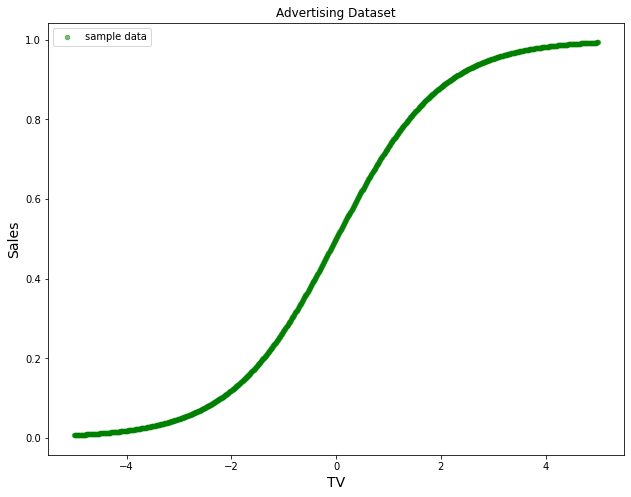

In [26]:
# Helper code to visualize the data 
plt.figure(figsize=(4,6))
plt.scatter(X_data, y_data,color='g' ,s = 20, alpha = 0.5, label='sample data')
plt.title('Advertising Dataset'); 
plt.xlabel('TV',fontsize=14); 
plt.ylabel('Sales',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

In [69]:
# Convert the predictor and response variables to tensor data
x = tf.convert_to_tensor(X_data)
x = tf.reshape(x,(-1,1))
y = tf.convert_to_tensor(y_data)
y = tf.reshape(y, (-1, 1))


In [178]:
# Function to define the neural network model
# The network has 2 hidden nodes and one output node
# The network has a total of 5 parameters - 4 weights and one bias for the output

def basic_nn(w0,w1,b1,x=x):
    h1 = tf.matmul(x,w0)
    a1 = tf.math.sin(h1)
    h2 = tf.matmul(a1,w1) + b1
    y = tf.math.sin(h2)
    return y


In [177]:
# Define 3 empty lists to store the accepted network parameters

# The weights0_list will contain 2 weights that connects the input
# to the hidden layer
weights0_list = []

# The weights1_list will contain 2 weights that connects the hidden
# nodes to the output
weights1_list = []

# The bias_list will hold the bias added to the output of the hidden nodes
bias_list = []

In [ ]:
# Initialize the input to hidden weights randomly from a normal distribution 
# with mean=(-0.4,12) and standard deviation=(0.1,0.1)
# Reshape the values to shape (1,2)
weights0 = tf.reshape(np.random.normal(loc=(-0.4,12),scale=(0.1,0.1), size=(1,2)), shape=(1,2))

# Initialize the hidden to output weights randomly from a normal distribution 
# with mean=(-0.4,12) and standard deviation=(0.1,0.1)
# Reshape the values to shape (2,1)
weights1 = tf.reshape(np.random.normal(loc=(0.6, 0),scale=(0.1)), shape=(2,1))

# Initialize the bias randomly from a normal distribution 
# with mean=2.5 and standard deviation=0.1
bias = np.random.normal(loc=2.5, scale=0.1)


In [181]:
# Function to get the prior given the network parameters
def get_prior(weights0,weights1, bias):

    # Initialize a numpy array of zeros with shape 2,1
    prior_w0 = np.zeros((2,1))
    
    # Find the probability of the first weight given the normal PDF with mean =-0.4 and std=0.1
    # Take the log of this value
    prior_w0[0] = np.log(norm.pdf(weights0[0][0],-0.4, 0.1))
    
    # Find the probability of the second weight given the normal PDF with mean =12 and std=0.1
    # Take the log of this value
    prior_w0[1] = np.log(norm.pdf(weights0[0][1],12, 0.1))

    # Initialize a numpy array of zeros with shape 2,1
    prior_w1 = np.zeros((2,1))  
    
    # Find the probability of the third weight given the normal PDF with mean =0.6 and std=0.1
    # Take the log of this value
    prior_w1[0] = np.log(norm.pdf(weights1[0],0.6,0.1))
    
    # Find the probability of the first weight given the normal PDF with mean =0 and std=0.1
    # Take the log of this value
    prior_w1[1] = np.log(norm.pdf(weights1[1],0,0.1))

    # Find the probability of the bias given the normal PDF with mean=2.5 and std=0.1
    # Take the log of this value
    prior_bias = np.log(norm.pdf(bias,2.5,0.1))
    
    # Compute the prior as the sum of the previously computed priors
    prior = np.sum(prior_w0[0]+prior_w0[1]+prior_w1[0]+prior_w1[1]+prior_bias)
  
    # Return the prior value
    return prior
    

In [182]:
# Get the prior of the initial network parameters by calling the get_prior function
prior = get_prior(weights0,weights1, bias)

# Get the network predictions by calling the basic_nn function
ypred = basic_nn(weights0, weights1, bias, x)

# Compute the likelihood given the true y and predicted y
likelihood = -np.sum(((y-ypred)**2))

# Compute the posterior as the sum of the likelihood and prior
posterior = likelihood + prior

# Save the current posterior value as prev_posterior for comparision later
prev_posterior = posterior

# Append weights0 to the weights0_list
weights0_list.append(weights0)

# Append weights1 to the weights1_list
weights1_list.append(weights1)

# Append bias to the bias_list
bias_list.append(bias)


In [183]:
# Specify the number of sampling "epochs"
epochs = 50000

# Loop over the range of sampling "epochs"
for i in range(epochs):
    if i%5000==0:
        print("EPOCH: ",i)

    # Get the candidate input to hidden weights randomly from a normal distribution 
    # with mean as the last element added to weights0_list and standard deviation=(0.1,0.1)
    # Reshape the values to shape (1,2)
    weights0 = tf.reshape(np.random.normal(loc=weights0_list[-1],scale=(0.1, 0.1)), shape=(1,2))

    # Get the candidate hidden to output weights randomly from a normal distribution 
    # with mean as the last element added to weights1_list and standard deviation=(0.1)
    # Reshape the values to shape (2,1)
    weights1 = tf.reshape(np.random.normal(loc=weights1_list[-1],scale=(0.1)), shape=(2,1))

    # Get the candidate bias randomly from a normal distribution 
    # with mean as the last element added to bias_list and standard deviation=(0.1)
    bias = np.random.normal(loc=bias_list[-1],scale=0.1)

    # Get the prior values for the candidate values by calling the get_prior function
    prior = get_prior(weights0,weights1, bias)

    # Get the network predictions by calling the basic_nn function with the candidate values
    ypred = basic_nn(weights0, weights1, bias, x)

    # Compute P(data|w) i.e. the log-likelihood given the true y and predicted y
    likelihood = -np.sum(((y - ypred)**2))

    # To compute the posterior given the likelihood and prior
    # The posterior is the sum of the likelihood and prior
    posterior = likelihood + prior

    # Compute the the exponential of the ratio of the posterior given its previous value
    exp_ratio = np.exp(posterior - prev_posterior)

    # If the ratio is greater than or equal to 1 then accept the candidate values in this case
    if exp_ratio>=1:

        # Append the candidate values to the weights and bias list
        weights0_list.append(weights0)
        weights1_list.append(weights1)
        bias_list.append(bias)

        # Save the accepted posterior as the previous posterior
        prev_posterior = posterior

    # If the ratio is less than 1 then get a random value between 0 and 1
    else:
        coin = np.random.uniform(0, 1)

        # Set a threshold value
        threshold = 0.98
        
        # Check if the random value is higher than the threshold
        # Append the candidate values to the list and update the previous posterior
        if coin > threshold:
            weights0_list.append(weights0)
            weights1_list.append(weights1)
            bias_list.append(bias)
            prev_posterior = posterior



EPOCH:  0
EPOCH:  5000
EPOCH:  10000
EPOCH:  15000
EPOCH:  20000
EPOCH:  25000
EPOCH:  30000
EPOCH:  35000
EPOCH:  40000
EPOCH:  45000


In [185]:
# The number of data points to consider after the beta list has been populated
burn_rate = int(len(bias_list)*0.2)

In [ ]:
# Helper code to plot the distribution of network parameter
fig, ax = plt.subplots(5,2, figsize=(15,15))
col1 = "#B2D7D0"
col2 = "#EFAEA4"
fs = 12

with plt.xkcd(scale=0.01):
  ax[0][0].hist(np.array(weights0_list)[:,0,0], color=col1,linewidth=1.2,edgecolor='black')
  ax[0][0].set_xlabel("Weight 1")
  ax[0][0].set_ylabel("Frequency")


  ax[0][1].plot(np.array(weights0_list)[:,0,0], color=col2)
  ax[0][1].set_xlabel("Weight 1")
  ax[0][1].set_title("CHAIN", fontsize=14)

  ax[1][0].hist(np.array(weights0_list)[:,0,1], color=col1,linewidth=1.2,edgecolor='black')
  ax[1][0].set_xlabel("Weight 2")
  ax[1][0].set_ylabel("Frequency")

  ax[1][1].plot(np.array(weights0_list)[:,0,1], color=col2)
  ax[1][1].set_xlabel("Weight 2")


  ax[2][0].hist(np.array(weights1_list)[:,0,0], color=col1,linewidth=1.2,edgecolor='black')
  ax[2][0].set_xlabel("Weight 3")
  ax[2][0].set_ylabel("Frequency")

  ax[2][1].plot(np.array(weights1_list)[:,0,0], color=col2)
  ax[2][1].set_xlabel("Weight 3")


  ax[3][0].hist(np.array(weights1_list)[:,1,0], color=col1,linewidth=1.2,edgecolor='black')
  ax[3][0].set_xlabel("Weight 4")
  ax[3][0].set_ylabel("Frequency")

  ax[3][1].plot(np.array(weights1_list)[:,1,0], color=col2)
  ax[3][1].set_xlabel("Weight 4")

  ax[4][0].hist(np.array(bias_list), color=col1,linewidth=1.2,edgecolor='black')
  ax[4][0].set_xlabel("Bias")
  ax[4][0].set_ylabel("Frequency")

  ax[4][1].plot(np.array(bias_list), color=col2)
  ax[4][1].set_xlabel("Bias")


plt.tight_layout();

In [ ]:
# Helper code to visualize the prediction by taking the mean of the network parameters
wl = np.array(weights0_list[burn_rate:])
wl2 = np.array(weights1_list[burn_rate:])
bi = np.array(bias_list[burn_rate:])

# Take the mean of the model parameters
w0 = np.mean(wl[:,0,:], axis=0).reshape(1,2)
w1 = np.mean(wl2[:,:,0], axis=0)
w1 = tf.reshape(tf.cast(w1, dtype='float32'), shape=(2,1))
b1 = np.mean(bi)

# Get the network prediction
h1 = tf.matmul(tf.cast(x, dtype='float32'), w0)
a1 = tf.math.sin(h1)
h2 = tf.matmul(a1,w1) + b1
y_pred = tf.math.sin(h2)

# Plot the true data and model prediction
plt.plot(X_data, y_data, 'b+', label="True Data")
plt.plot(X_data, y_pred, 'ro', label = "Prediction")
plt.legend()